# Libraries and Data

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Load Dataset

In [11]:
df = pd.read_csv('weekly_customer_complaints.csv', parse_dates = True, index_col = 'week')
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [13]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

1. The number of complaints are in object, we need to set it into numbers.
2. `freq = None` for index, change it to week for further explorations

In [14]:
# return the number of complaints as number
df['complaints'] = df['complaints'].str.replace(',','').astype(int)

# return the freq of index into Week, where the recap always starts from Monday
df.asfreq('W-MON')

# show data
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


In [113]:
# save it into data of historical complaints
data = df['complaints'].asfreq('W-MON').copy()

# Exploratory Data Analysis

## Show the data in high level and compositions: Trend and Seasonality

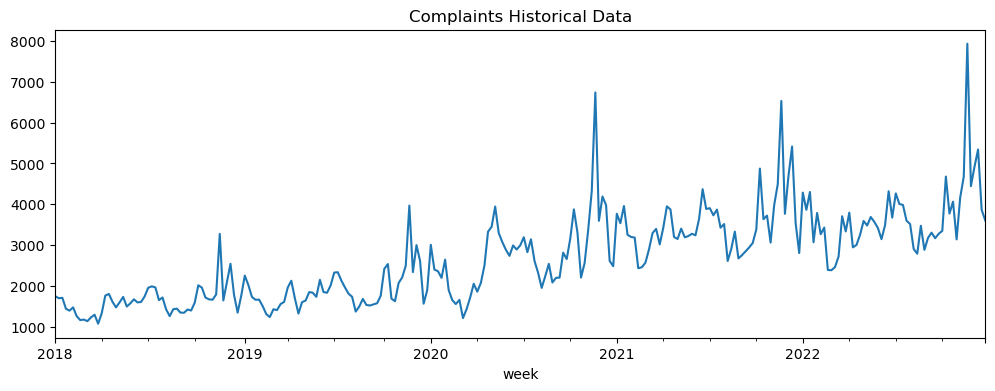

In [33]:
data.plot(figsize=(12, 4), title='Complaints Historical Data')
plt.show();

seem that the trend is increasing with time. also it seems that there is seasonality and multiplicative behavior of trend and seasonality. But we need further inspect

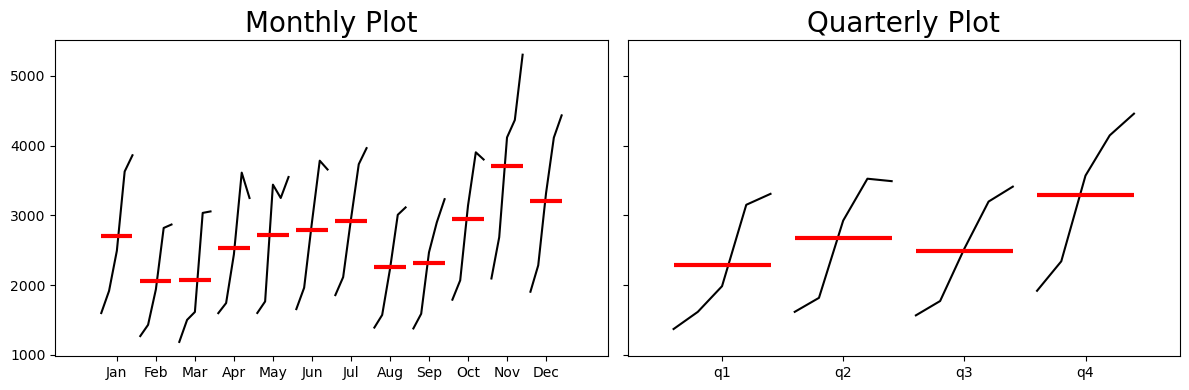

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4), sharey=True)

month_plot(data.resample('ME').mean(), 
           ax=ax1)
quarter_plot(data.resample('QE').mean(), 
             ax=ax2)

ax1.set_title("Monthly Plot", size=20)
ax2.set_title("Quarterly Plot", size=20)
plt.tight_layout()
plt.plot();

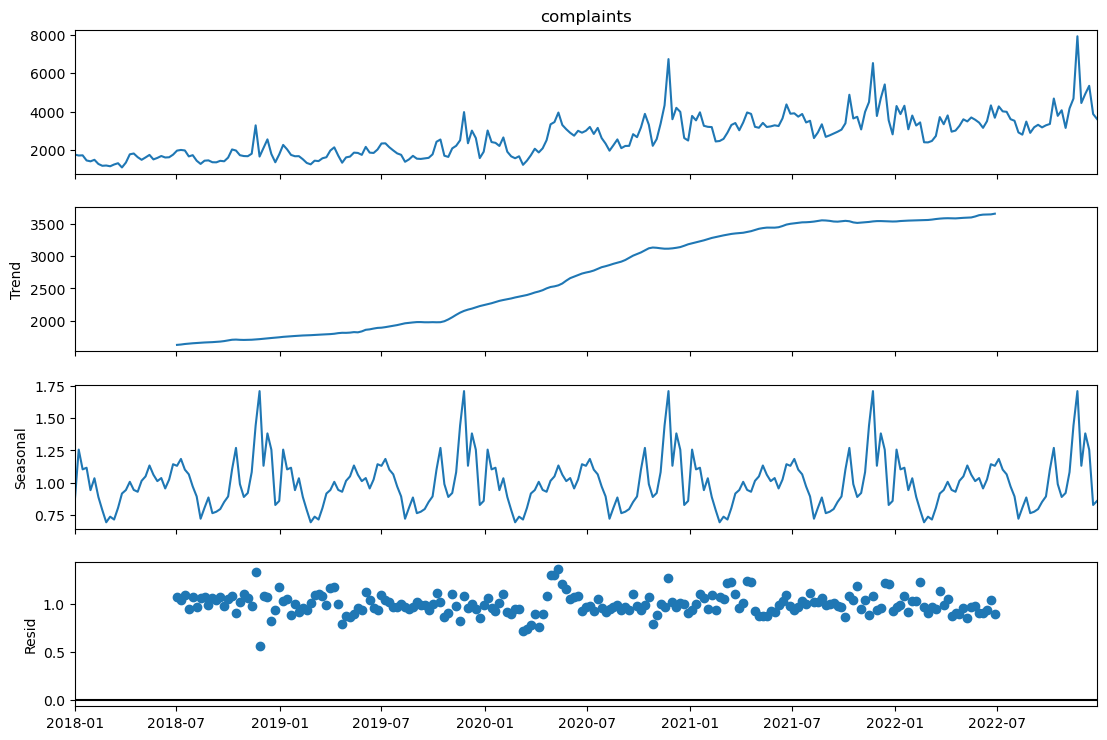

In [47]:
# Seasonal Decomposition Plots for complaint values
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['complaints'],
                                   model = 'mul',
                                   period = 52)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

after some decomposition process, seems that the trend in the last 2 years was going flat. and the concept of Multiplicative Seasonality seems to be not really rellevant in this periods. So in the next modelling, we need to try 2 approches, one using multiplicative and the other use additive then evaluate the results.

## Autorcorrelation and Partial Autocorrelation Plot

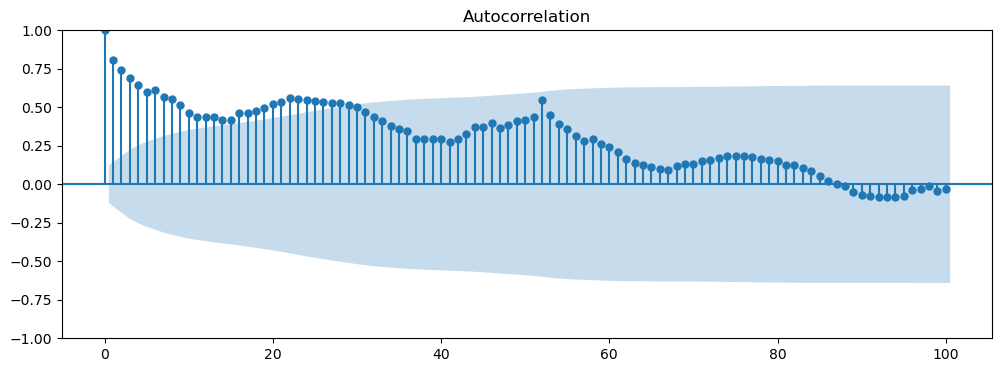

In [44]:
# Plot the autocorrelation (ACF) of complaint values
fig, ax = plt.subplots(figsize = (12,4))
plot_acf(df['complaints'], lags = 100, ax = ax)
plt.show()

**From Acutocorrelation:**

There is information from the last weeks that has been preserfed in general. but there's a spike around week 52, which is a period of a year ago that has strong correlation compared to other.

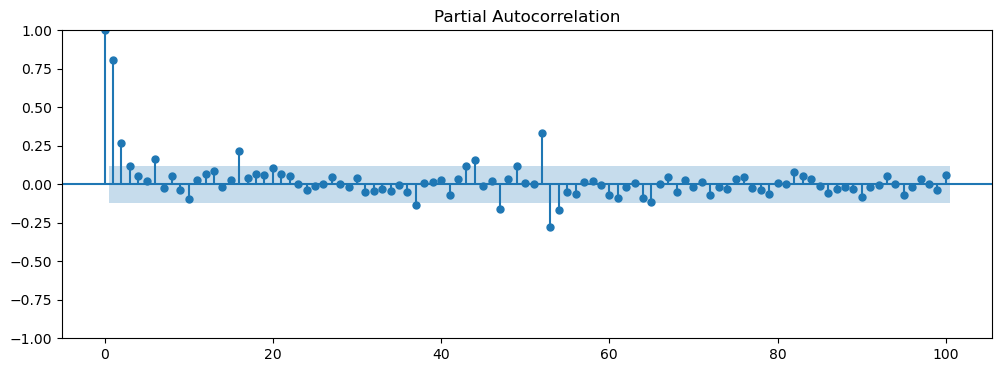

In [45]:
# Plot the autocorrelation (ACF) of complaint values
fig, ax = plt.subplots(figsize = (12,4))
plot_pacf(df['complaints'], lags = 100, ax = ax)
plt.show()

**From Partial-Acutocorrelation:**

The correlation of direct impact of previous periods seems to be more clear, where there is strong direct correlations from previous Two Weeks, and seasonality within 1 year period (week-52).

# Get Training and Testing Data

In [57]:
# when splitting, it's important to note that the numb of periods of testing is the number of periods we try to forcast
# in this case, we will try to forecast the next 3 months complaints, so we choose 12 as a period (12 weeks = 3 months)
periods = 12

train = data[:-periods].asfreq('W-MON').copy()
test = data[-periods:].asfreq('W-MON').copy()

In [58]:
#check the separation results

train.tail()

week
2022-09-05    3177
2022-09-12    3306
2022-09-19    3170
2022-09-26    3279
2022-10-03    3350
Freq: W-MON, Name: complaints, dtype: int32

In [59]:
test.head()

week
2022-10-10    4679
2022-10-17    3773
2022-10-24    4065
2022-10-31    3142
2022-11-07    4164
Freq: W-MON, Name: complaints, dtype: int32

# Modelling
## Simple Exponential Smoothing

Simple Exponential Smoothing assigns exponentially decreasing weights to past observations, giving more influence to recent data.

It is especially useful when there is no clear trend or seasonal pattern.

In [84]:
# Create a Simple Exponential Smoothing model using the training data.
simple_smoothing = SimpleExpSmoothing(train).fit()

# Use the fitted model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_simple = simple_smoothing.forecast(len(test))

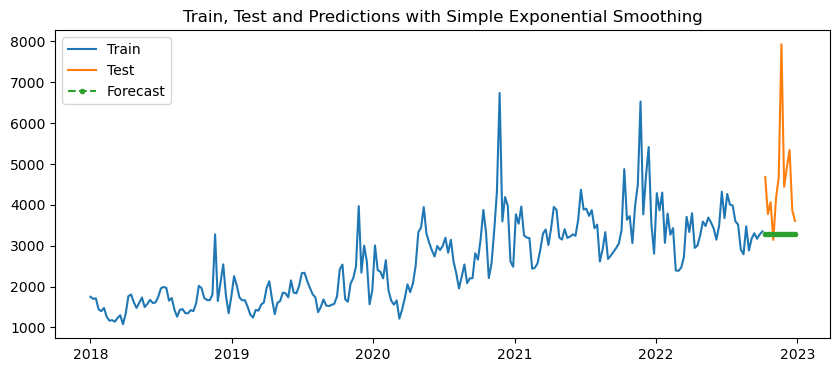

In [140]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_simple, label = "Forecast", linestyle='--', marker='.')

# add title and legend to the plot
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

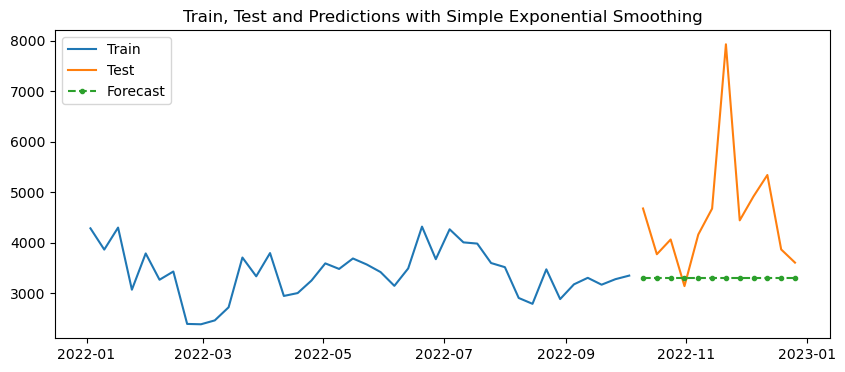

In [139]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train['2022'], label = 'Train')
plt.plot(test['2022'], label = 'Test')
plt.plot(predictions_simple, label = "Forecast", linestyle='--', marker='.')

# add title and legend to the plot
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

## Double Exponential Smoothing

Double Exponential Smoothing (DES), also known as Holt’s Linear Trend Model, is used when the time series data exhibits a trend.

Unlike Simple Exponential Smoothing, which is suitable for data without trends or seasonality, DES can account for both the level and the trend in the data

Key Features:
- Trend Handling - making it suitable for time series data that show a consistent upward or downward trend over time.
- Components - DES involves two components: the level (smoothed value) and the trend.

In [92]:
# Create a Double Exponential Smoothing model using the training data.

# double smoothing for additive model
double_smoothing1 = Holt(train, 
                         exponential=False).fit()

# double smoothing for multiplicative
double_smoothing2 = Holt(train, 
                         exponential=True).fit()

# Use the fitted model to forecast future values.
predictions_double1 = double_smoothing1.forecast(len(test))
predictions_double2 = double_smoothing2.forecast(len(test))

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


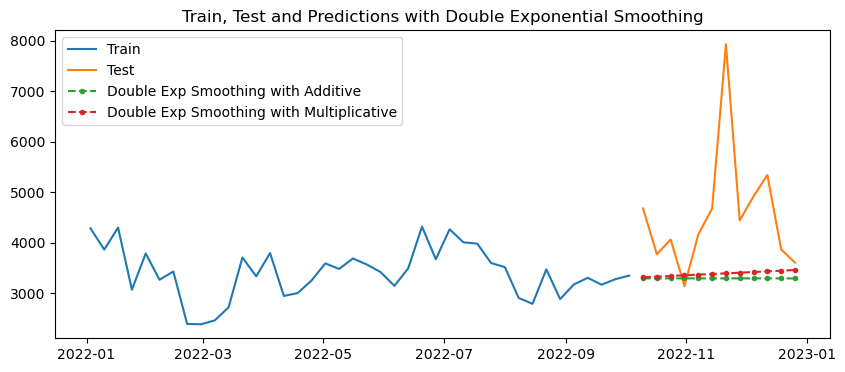

In [138]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train['2022'], label = 'Train')
plt.plot(test['2022'], label = 'Test')
plt.plot(predictions_double1['2022'], label='Double Exp Smoothing with Additive', 
         linestyle='--', marker='.')
plt.plot(predictions_double2['2022'], label='Double Exp Smoothing with Multiplicative', 
         linestyle='--', marker='.')

# add title and legend to the plot
plt.title("Train, Test and Predictions with Double Exponential Smoothing")
plt.legend()
plt.show()

without using matix, it's seems that `Multiplicative` behavior still appear within the current region where the prediction line fit better than prediction line of additive. so in the next modelling, we will use multiplicative.

# Triple Exponential Smoothing (Holt-Winters Method)

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [96]:
# Triple Exponential Smoothing Model
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)

model_triple1 = ExponentialSmoothing(train,
                                    trend = 'add',
                                    seasonal = "mul",
                                    seasonal_periods = 52).fit()
model_triple2 = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "add",
                                    seasonal_periods = 52).fit()
model_triple3 = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 52).fit()


# Use the fitted model to forecast future values.
predictions_triple1 = model_triple1.forecast(len(test))
predictions_triple2 = model_triple2.forecast(len(test))
predictions_triple3 = model_triple3.forecast(len(test))

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


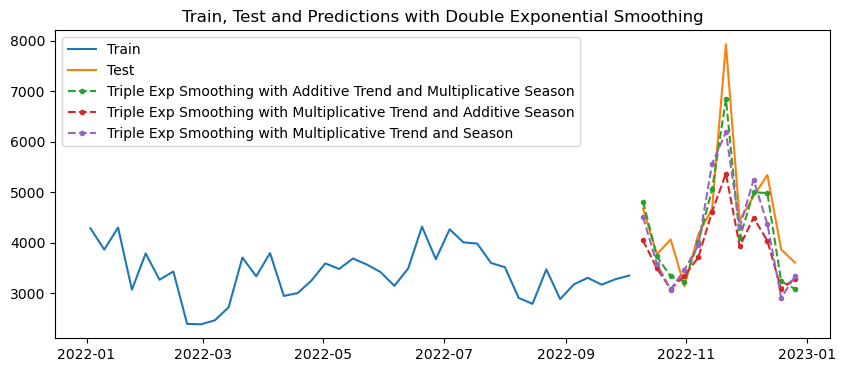

In [137]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train['2022'], label = 'Train')
plt.plot(test['2022'], label = 'Test')
plt.plot(predictions_triple1['2022'], label='Triple Exp Smoothing with Additive Trend and Multiplicative Season', 
         linestyle='--', marker='.')
plt.plot(predictions_triple2['2022'], label='Triple Exp Smoothing with Multiplicative Trend and Additive Season', 
         linestyle='--', marker='.')
plt.plot(predictions_triple3['2022'], label='Triple Exp Smoothing with Multiplicative Trend and Season', 
         linestyle='--', marker='.')

# add title and legend to the plot
plt.title("Train, Test and Predictions with Double Exponential Smoothing")
plt.legend()
plt.show()

In [107]:
scorers = [mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error]

res = pd.DataFrame(
    index = ['MAE', 'RMSE', 'MAPE'],
    columns = ['Tred Add, Season Mult', 'Tred Mult, Season Add', 'Trend Mult, Season Mult']
)

for i, s in enumerate(scorers):
    res.iloc[i, :] = [s(test, predictions_triple1), 
                      s(test, predictions_triple2),
                      s(test, predictions_triple3)]

res

,"Tred Add, Season Mult","Tred Mult, Season Add","Trend Mult, Season Mult"
MAE,379.7397,709.538068,597.859747
RMSE,485.805386,961.962965,768.260462
MAPE,0.081118,0.141409,0.124552


The model is Holt-Winter with Additional Trend and Multiplicative Seasonal Component

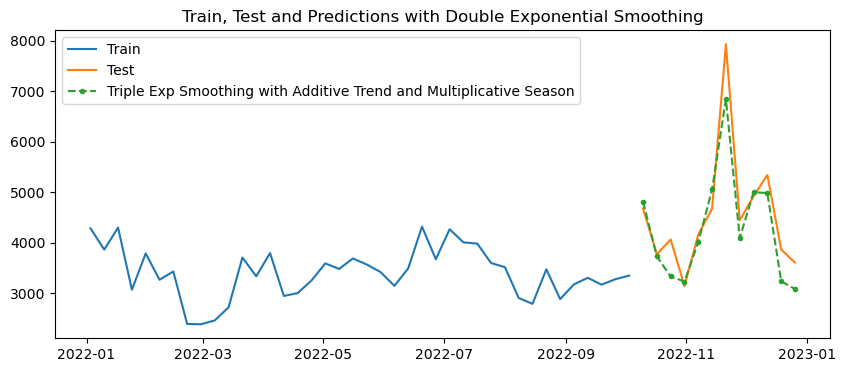

In [141]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train['2022'], label = 'Train')
plt.plot(test['2022'], label = 'Test')
plt.plot(predictions_triple1['2022'], label='Triple Exp Smoothing with Additive Trend and Multiplicative Season', 
         linestyle='--', marker='.')

# add title and legend to the plot
plt.title("Train, Test and Predictions with Double Exponential Smoothing")
plt.legend()
plt.show()

In [110]:
print(model_triple1.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  249
Model:             ExponentialSmoothing   SSE                       22494228.365
Optimized:                         True   AIC                           2953.418
Trend:                         Additive   BIC                           3150.395
Seasonal:                Multiplicative   AICC                          2989.439
Seasonal Periods:                    52   Date:                 Wed, 02 Oct 2024
Box-Cox:                          False   Time:                         23:52:21
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2171429                alpha                 True
smoothing_trend          

# Prediction for Future Complaints

In [114]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the whole data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)
model = ExponentialSmoothing(data,
                             trend = 'add',
                             seasonal = "mul",
                             seasonal_periods = 52).fit()

In [115]:
 # Predict the values for the next 13 weeks
forecast = model.forecast(periods)
forecast

2023-01-02    4837.697310
2023-01-09    4369.892032
2023-01-16    4578.729070
2023-01-23    3712.254227
2023-01-30    4132.256206
2023-02-06    3623.016843
2023-02-13    3287.528744
2023-02-20    2786.143462
2023-02-27    2877.965774
2023-03-06    2941.779042
2023-03-13    3315.504716
2023-03-20    3797.370002
Freq: W-MON, dtype: float64

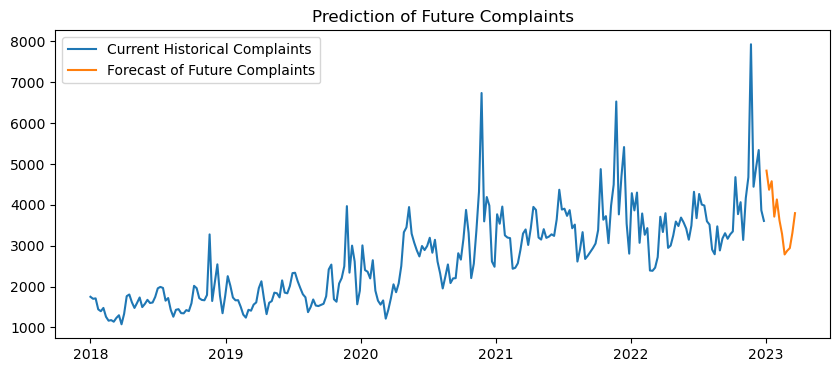

In [116]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(data, label = 'Current Historical Complaints')
plt.plot(forecast, label = "Forecast of Future Complaints")

# add title and legend to the plot
plt.title("Prediction of Future Complaints")
plt.legend()
plt.show()

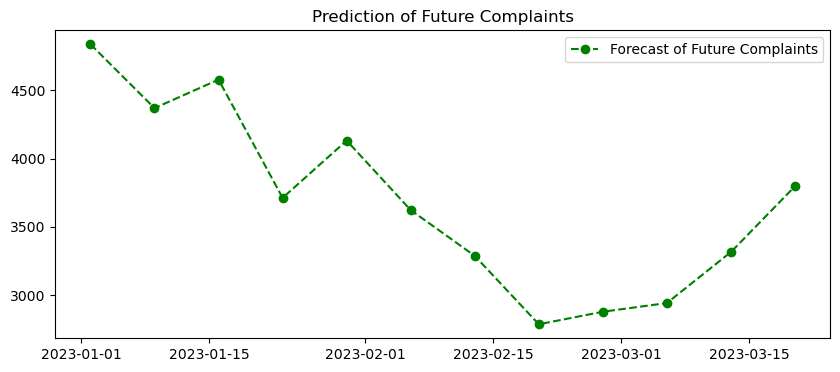

In [133]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(forecast, label = "Forecast of Future Complaints", linestyle='--', marker='o', color='g')

# add title and legend to the plot
plt.title("Prediction of Future Complaints")
plt.legend()
plt.show()